In [1]:
import pandas as pd
import numpy as np
import random
import csv
from prettytable import PrettyTable
from pylab import *
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
###Change the data file directory below appropriately
data = pd.read_csv('../aggregated_data/aggregated_data.csv')
data.head()

,UUID,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,00EABED2-271D-49D8-B599-1D4A09240601,1444079161,0.996815,0.003529,-0.002786,0.006496,0.995203,0.996825,0.998502,1.748756,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
1,00EABED2-271D-49D8-B599-1D4A09240601,1444079221,0.996864,0.004172,-0.003110,0.007050,0.994957,0.996981,0.998766,1.935573,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
2,00EABED2-271D-49D8-B599-1D4A09240601,1444079281,0.996825,0.003667,0.003094,0.006076,0.994797,0.996614,0.998704,2.031780,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
3,00EABED2-271D-49D8-B599-1D4A09240601,1444079341,0.996874,0.003541,0.000626,0.006059,0.995050,0.996907,0.998690,1.865318,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
4,00EABED2-271D-49D8-B599-1D4A09240601,1444079431,0.997371,0.037653,0.043389,0.102332,0.995548,0.996860,0.998205,0.460806,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2


# Interpolating acceleration columns with average values

In [3]:
def interpolation(df):
    col_to_avg = list(df.columns) #Start with keeping all the columns as columns to use an average interpolation on
    for k in range(len(list(df.columns))):
        if list(df.columns)[k].startswith(('discrete', 'label')): #Remove label and discrete columns from col_to_avg
            col_to_avg.remove(list(df.columns)[k])
    
    df_with_avg = df[col_to_avg].fillna(df[col_to_avg].mean()) #Interpolate nan columns for all continuous-valued columns with average
    
    col_to_zero = list(df.columns)
    for k in range(len(list(df.columns))):
        if not list(df.columns)[k].startswith(('discrete', 'label')): #Remove all columns except label and discrete
            col_to_zero.remove(list(df.columns)[k])
    
    df_with_zero = df[col_to_zero].fillna(0) #Interpolate nan values for label and discrete columns with 0
    
    return pd.concat([df_with_avg, df_with_zero], axis = 1)

# Splitting the data and loading it into a PyTorch dataloader

In [4]:
X = data.iloc[:,1:27]
y = data[['label:SITTING']]

X = X[y['label:SITTING'] == 1]
y = y[y['label:SITTING'] == 1]

X = interpolation(X).values
y = interpolation(y).values

print(len(X), len(y))

136356 136356


In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
#X

# Helper Functions for Training

In [12]:
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = True)
    )
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim)

class Generator(nn.Module):
    def __init__(self, z_dim = 10, feature_dim = 26, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            generator_block(z_dim, int(hidden_dim/2)),
            generator_block(int(hidden_dim/2), int(hidden_dim/4)),
            generator_block(int(hidden_dim/4), 30),
            generator_block(30, feature_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)

def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

class Discriminator(nn.Module):
    def __init__(self, feature_dim = 26, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(feature_dim, hidden_dim),
            discriminator_block(hidden_dim, int(hidden_dim/2)),
            discriminator_block(int(hidden_dim/2), int(hidden_dim/4)),
            nn.Linear(int(hidden_dim/4), 1),
            nn.Sigmoid()                    
        )
    def forward(self, feature_vector):
        return self.disc(feature_vector)

def get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred_fake = disc(fake_features.detach())
    
    ground_truth = torch.zeros_like(pred_fake)
    loss_fake = criterion(pred_fake, ground_truth)
    
    pred_real = disc(real_features)
    ground_truth = torch.ones_like(pred_real)
    loss_real = criterion(pred_real, ground_truth)
    
    disc_loss = (loss_fake + loss_real) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred = disc(fake_features)
    gen_loss = criterion(pred, torch.ones_like(pred))
    return gen_loss

def visualize_gen_batch(gen, b_size, epochs = -1):
    #print(str(b_size))
    latent_vectors = get_noise(b_size, z_dim)
    #print(latent_vectors.shape)
    fake_features = gen(latent_vectors)
    #print(fake_features.shape)
    
    w_img = fake_features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Generated Batch at Epoch ' + str(epochs), fontweight ="bold")
    plt.show()
    
def visualize_real_batch(features):
    w_img = features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Real Batch of Data', fontweight ="bold")
    plt.show()
    
def performance_stats(gen, disc, b_size, batch = None):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    with torch.no_grad():
        if batch is None:
            latent_vectors = get_noise(b_size, z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * b_size
            y_label = torch.Tensor(y_label)
        else:
            latent_vectors = get_noise(int(b_size/2), z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * int(b_size/2)
            
            real_y_hat = torch.round(disc(batch[:int(b_size/2)]))
            for i in range(0, int(b_size/2)):
                y_label.append(1)
            y_hat = torch.cat((y_hat, real_y_hat), dim = 0)
            
            #print(y_hat)
            #print(y_label)
         
        
        for k in range(len(y_hat)):
            #True positive
            if y_label[k] == 1 and y_hat[k] == 1:
                tp += 1
            #False Negative
            elif y_label[k] == 1 and y_hat[k] == 0:
                fn += 1
            #True Negative
            elif y_label[k] == 0 and y_hat[k] == 0:
                tn += 1
            elif y_label[k] == 0 and y_hat[k] == 1:
                fp += 1
            
        class_acc = (tp + tn)/(tp + tn + fp + fn)
        
        if tp + fp == 0:
            precision = 0
        else:
            precision = tp / (tp + fp)
            
        if tp + fn == 0:
            recall = 0
        else:
            recall = tp / (tp + fn)
            
        if fp + tn == 0:
            fpR = 0
        else: 
            fpR = fp / (fp + tn)

        #print(f'Classification Accuracy: {class_acc:.2f}')
        #print(f'Precision: {precision:.2f}') #What percentage of a model's positive predictions were actually positive
        #print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
        #print(f'F-1 Score: {2*(precision * recall / (precision + recall + 0.001)):.2f}')
        return class_acc, precision, recall, fpR, 2*(precision * recall / (precision + recall + 0.001))
    
    
def density_curves(reals, fakes):
    plt.figure(figsize = (15, 15))
    subplot(2, 2, 1)
    sns.kdeplot(fakes[:,0], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,0], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 2)
    sns.kdeplot(fakes[:,18], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,18], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean X-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 3)
    sns.kdeplot(fakes[:,19], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,19], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Y-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 4)
    sns.kdeplot(fakes[:,20], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,20], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Z-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def get_fake_samples(gen, batch_size, z_dim):
    """
    Generates fake acceleration features given a batch size, latent vector dimension, and trained generator.
    
    """
    latent_vectors = get_noise(batch_size, z_dim) ### Retrieves a 2D tensor of noise
    fake_features = gen(latent_vectors)
    
    return fake_features ### Returns a 2D tensor of fake features of size batch_size x z_dim



# Model Hyperparameters (Always Run Again Before Starting Training Loop) 

In [7]:
# Loss function for model
criterion = nn.BCELoss()

#GAN Name (used for saving model and its output)
gan_id = "Test Gan"

# Digit Precision for printouts
dig = 5

# Max epochs to run
n_epochs = 100

# Number of dimensions of latent vector
z_dim = 100

# Batch Size
batch_size = 1000

# Learning Rates for Generator (Gen) and Discriminator (Disc)
gen_lr =  0.0001
disc_lr = 0.0001

# Constant epochs approach to train Discriminator, Generator
constant_train_flag = False # Set to true to train based on constant # of epochs per machine 
                            # Set to false to train dynamically based on machine performance
disc_epochs = 5             # Number of consecutive epochs to train discriminator before epoch threshold
gen_epochs = 2              # Number of consecutive epochs to train generator before epoch threshold
epoch_threshold = 50        # Epoch number to change training epoch ratio
disc_epochs_change = 1      # New number of consecutive epochs to train discriminator
gen_epochs_change = 50      # New number of consecutive epochs to train generator
rel_epochs = 0              # Epochs passed since last switch (always set to 0)


# Dynamic number of epochs to train Discriminator, Generator
static_threshold = 12   # Epoch number to change from static ratio to dynamic
static_disc_epochs = 4  # Number of consecutive epochs to train discriminator before epoch threshold
static_gen_epochs = 2   # Number of consecutive epochs to train generator before epoch threshold
pull_threshold = 0.4   # Accuracy threshold for switching machine training when the generator is no longer competitive
push_threshold = 0.6   # Accuracy threshold for switching machine training when the discriminator is no longer competitive

# Which machine to train (0 for Generator, 1 for Discriminator) !!!(do not change unless for good reason)!!!
GENERATOR = 0
DISCRIMINATOR = 1
to_train = DISCRIMINATOR
train_string = "DISC"

# Show model performance per batch (will always show summary for each epoch)
print_batches = False

# Moving corpus data into a pyTorch format !!!(do not change unless for good reason)!!!
train_features = torch.tensor(X)
train_labels = torch.tensor(y)
train_data = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

# Initializiing the Machines !!!(do not change unless for good reason)!!!
disc = Discriminator()
gen = Generator(z_dim)
opt_disc = optim.Adam(disc.parameters(), lr = disc_lr)
opt_gen = optim.Adam(gen.parameters(), lr = gen_lr)

# Training Loop

In [8]:
#For saving prettyTable.txt file
heading = ["Epoch", "Machine Training", "Discriminator Loss", "Generator Loss", "Accuracy", "fp Rate", "Precision", "Recall", "F1-Score"]
table = PrettyTable()
table.field_names = heading

#For saving .csv file
rows = []

last_real_features = []
switch_flag = False
switch_count = 0

for epoch in range(n_epochs):  
    if constant_train_flag:
        if to_train == DISCRIMINATOR and rel_epochs >= disc_epochs:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GEN"

        elif to_train == GENERATOR and rel_epochs >= gen_epochs:
            rel_epochs = 0
            to_train = DISCRIMINATOR
            train_string = "DISC"
        
        # Change epoch ratio after intial 'leveling out'
        if epoch == epoch_threshold:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GENERATOR"

            old_ratio = gen_epochs / disc_epochs
            gen_epochs = gen_epochs_change
            disc_epochs = disc_epochs_change
            new_ratio = gen_epochs / disc_epochs
            print(f'\n\nTraining ratio of G/D switched from {old_ratio:.{dig}f} to {new_ratio:.{dig}f}\n\n')
    else:
        if epoch < static_threshold:
            if to_train == DISCRIMINATOR and rel_epochs >= static_disc_epochs:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"

            elif to_train == GENERATOR and rel_epochs >= static_gen_epochs:
                rel_epochs = 0
                to_train = DISCRIMINATOR
                train_string = "DISC"
        
        else:
            if not switch_flag:
                print("\nSwitching to Dynamic Training\n")
                switch_flag = True
            if to_train == DISCRIMINATOR and fpR <= pull_threshold:
                to_train = GENERATOR
                train_string = "GEN"
                print("\nPull Generator\n")
                switch_count += 1
            if to_train == GENERATOR and fpR >= push_threshold:
                to_train = DISCRIMINATOR
                train_string = "DISC"
                print("\nPush Generator\n")
                switch_count += 1

    print(f'Epoch [{epoch + 1}/{n_epochs}] Training: {train_string} ', end ='')
    for batch_idx, (real_features, _) in enumerate(train_loader):
        #batch_size = len(real_features)
    
        if print_batches:
                print(f'\n\tBatch [{batch_idx + 1} / {len(train_loader)}] |', end ='')
    
        if to_train == DISCRIMINATOR:
            ### Training Discriminator
            #visualize_real_batch(real_features.float())
            opt_disc.zero_grad()
            disc_loss = get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim)
            disc_loss.backward(retain_graph = True)
            opt_disc.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, batch_size, batch = real_features.float())
            if print_batches:
                print(f'Loss D: {disc_loss.item():.digf}, Loss G: {get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f}')
        else:
            ### Training Generator
            opt_gen.zero_grad()
            gen_loss = get_gen_loss(gen, disc, criterion, batch_size, z_dim)
            gen_loss.backward()
            opt_gen.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, batch_size, batch = real_features.float())
            if print_batches:
                print(f'Loss D: {get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim):.{dig}f}, Loss G: {gen_loss.item():.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f}')
        
    if not print_batches:
        if to_train == DISCRIMINATOR:
            print(f'| Loss D: {disc_loss.item():.{dig}f}, Loss G: {get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Discriminator", f"{disc_loss.item():.{dig}f}", f"{get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f}", f"{acc:.{dig}f}", f"{fpR:.{dig}f}", f"{P:.{dig}f}", f"{R:.{dig}f}", f"{F1:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
        else:
            print(f'| Loss D: {get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim):.{dig}f}, Loss G: {gen_loss.item():.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Generator", f"{get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim):.{dig}f}", f"{gen_loss.item():.{dig}f}", f"{acc:.{dig}f}", f"{fpR:.{dig}f}", f"{P:.{dig}f}", f"{R:.{dig}f}", f"{F1:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
    rel_epochs += 1

    
print("\n\nTraining Session Finished")
print(f"Encountered {switch_count} non-trivial training swaps")

f = open("../model_outputs/" + gan_id + ".txt", "w")
f.write(table.get_string())
f.close()
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".txt\"")

with open("../model_outputs/" + gan_id + ".csv", "w") as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
    # writing the fields 
    csvwriter.writerow(heading)
    # writing the data rows 
    csvwriter.writerows(rows)
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".csv\"")

Epoch [1/100] Training: DISC | Loss D: 0.69279, Loss G: 0.56782 | Accuracy: 0.41589 | fpR: 1.00000 | P: 0.41589 | R: 1.00000 | F1: 0.58704
Epoch [2/100] Training: DISC | Loss D: 0.67848, Loss G: 0.58189 | Accuracy: 0.41589 | fpR: 1.00000 | P: 0.41589 | R: 1.00000 | F1: 0.58704
Epoch [3/100] Training: DISC | Loss D: 0.65602, Loss G: 0.60511 | Accuracy: 0.41589 | fpR: 1.00000 | P: 0.41589 | R: 1.00000 | F1: 0.58704
Epoch [4/100] Training: DISC | Loss D: 0.61010, Loss G: 0.65871 | Accuracy: 0.58762 | fpR: 0.70600 | P: 0.50212 | R: 1.00000 | F1: 0.66810
Epoch [5/100] Training: GEN | Loss D: 0.61274, Loss G: 0.66068 | Accuracy: 0.54790 | fpR: 0.77400 | P: 0.47914 | R: 1.00000 | F1: 0.64742
Epoch [6/100] Training: GEN | Loss D: 0.61165, Loss G: 0.65593 | Accuracy: 0.48715 | fpR: 0.87800 | P: 0.44780 | R: 1.00000 | F1: 0.61817
Epoch [7/100] Training: DISC | Loss D: 0.55115, Loss G: 0.74672 | Accuracy: 0.86916 | fpR: 0.22200 | P: 0.76180 | R: 0.99719 | F1: 0.86326
Epoch [8/100] Training: DISC 

Epoch [60/100] Training: GEN | Loss D: 0.33716, Loss G: 1.26629 | Accuracy: 0.92173 | fpR: 0.11200 | P: 0.86035 | R: 0.96910 | F1: 0.91099
Epoch [61/100] Training: GEN | Loss D: 0.33135, Loss G: 1.28042 | Accuracy: 0.92991 | fpR: 0.10600 | P: 0.86816 | R: 0.98034 | F1: 0.92035
Epoch [62/100] Training: GEN | Loss D: 0.34144, Loss G: 1.26495 | Accuracy: 0.92290 | fpR: 0.09800 | P: 0.87371 | R: 0.95225 | F1: 0.91079
Epoch [63/100] Training: GEN | Loss D: 0.33090, Loss G: 1.26091 | Accuracy: 0.92874 | fpR: 0.10600 | P: 0.86783 | R: 0.97753 | F1: 0.91892
Epoch [64/100] Training: GEN | Loss D: 0.32533, Loss G: 1.29278 | Accuracy: 0.91355 | fpR: 0.12200 | P: 0.84901 | R: 0.96348 | F1: 0.90213
Epoch [65/100] Training: GEN | Loss D: 0.32325, Loss G: 1.27073 | Accuracy: 0.93925 | fpR: 0.08600 | P: 0.88974 | R: 0.97472 | F1: 0.92980
Epoch [66/100] Training: GEN | Loss D: 0.33263, Loss G: 1.25061 | Accuracy: 0.91121 | fpR: 0.13400 | P: 0.83816 | R: 0.97472 | F1: 0.90080
Epoch [67/100] Training: GE

# Saving the Model

In [9]:
# Change path and name of the Generator and Discriminator accordingly
#torch.save(gen.state_dict(), "../saved_models/test_gan")
#torch.save(disc.state_dict(), "../saved_models/test_disc")

# Visualizing Generation Quality

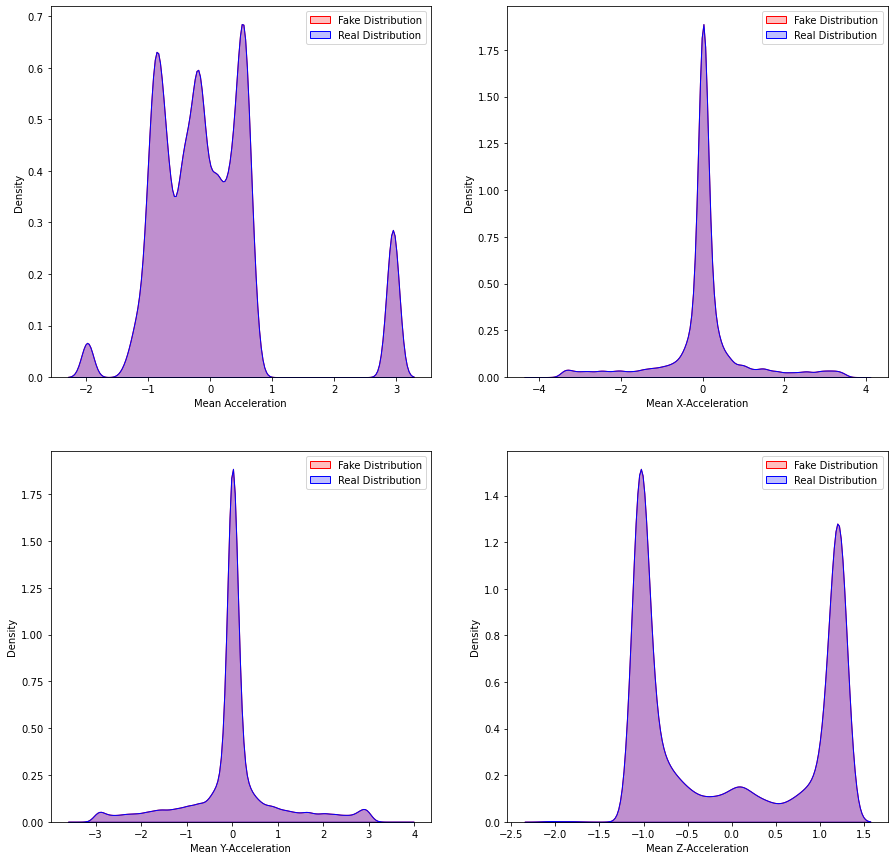

In [13]:
#Number of datum to visualize
sample_size = len(X)
reals = X[0:sample_size, :]
fakes = get_fake_samples(gen, sample_size, z_dim).detach()
density_curves(reals, reals)